In [18]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score

In [2]:
import seaborn as sns
sns.set_style('darkgrid')
import requests
import sys
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ast
import random
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk.text import Text
from datetime import datetime, timedelta
import string
import yake

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
def rmse(true, prediction):
    return np.sqrt(np.sum(np.power(true-prediction,2))/len(true))

def mean_err(true, prediction):
    return np.sum(true-prediction)/len(true)

def powerset_no_empty(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
    return power_set[1:]


In [5]:
# create a connection to the WSB database file
conn = sqlite3.connect("reddit_wallstreetbets.db")

# create our cursor (this allows us to execute SQL code chunks written as python strings)
c = conn.cursor()


In [6]:
#Print out database numbers before ending iteration
c.execute("SELECT * FROM new_posts")
new_posts_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
print( 'new_posts now has '+str(len(new_posts_df))+' entries.' )
c.execute("SELECT * FROM post_stats")
post_stats_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
print( 'post_stats now has '+str(len(post_stats_df))+' entries.' )


new_posts now has 6144 entries.
post_stats now has 129693 entries.


In [7]:
incomplete_entries = []
upvotes_24hrs = []
top_hot_loc = []
for i in range(len(new_posts_df)):
    c.execute("SELECT upvotes FROM post_stats where hour=24 and post_id="+str(i))
    fetch_val = c.fetchall()
    if len( fetch_val ) < 1:
        incomplete_entries.append(i)
    else:
        upvotes_24hrs.append( fetch_val[0][0] )
    c.execute("SELECT hot_val FROM post_stats where post_id="+str(i))
    top_hot_loc.append( min(c.fetchall())[0] )


In [8]:
time_vals = []
days = []
for i in range(len(new_posts_df)):
    time_str = new_posts_df["submit_time"][i].split('T')[1]
    time_val = float(time_str.split(':')[0])+float(time_str.split(':')[1])/60.+float(time_str.split(':')[2])/360.
    time_vals.append(time_val)
    days.append( pd.Timestamp( new_posts_df["submit_time"][i].split('T')[0].replace('"','') ).day_name() )

new_posts_df['submit_hour'] = time_vals
new_posts_df['submit_day'] = days
new_posts_df['best_hot_val'] = top_hot_loc

WSB_df = new_posts_df.drop(incomplete_entries)
WSB_df['upvotes_tot'] = upvotes_24hrs

WSB_df['redditor_for'] = WSB_df['redditor_for'] - min(WSB_df['redditor_for'])


#Need a definition of 'viral'
#Let's go with more than 2,500 upvotes or making it to the top 5 of the page
viral = []
for post_id in WSB_df['post_id']:
    if (WSB_df['upvotes_tot'][post_id] >= 684):#2500):
        viral.append(1)
    #elif (WSB_df['best_hot_val'][post_id] <= 5):
    #    viral.append(1)
    else:
        viral.append(0)

WSB_df['viral'] = viral
#Let's ignore daily discussion threads, since they are at the top of the page but not really viral
#WSB_df = WSB_df.drop(WSB_df[WSB_df['flair']=='Daily Discussion'].index)


In [9]:
#Get one-hot encoded day and flair variables and add them to the df
WSB_df = pd.concat([WSB_df, pd.get_dummies(WSB_df['flair'])], axis=1)
WSB_df = pd.concat([WSB_df, pd.get_dummies(WSB_df['submit_day'])], axis=1)



In [10]:
title = WSB_df['title']

symbolset = string.punctuation

n = len(title)
WSB_df["propernouns"] = np.zeros(n)
WSB_df["numbers"] = np.zeros(n)
WSB_df["hashtags"] = np.zeros(n)
WSB_df["symbols"] = np.zeros(n)
for i in title.index:
    text = title[i]
    words = nltk.word_tokenize(text)
    taggedtoken = nltk.pos_tag(words)
    NPcount = 0
    NUMcount = 0
    SYMcount = 0
    HASHcount = 0
    for word in taggedtoken:
        if word[1] == "NNP" or word[1] == "NNPS":
            NPcount += 1
        if word[1] == "JJ" or word[1] == "CD":
            NUMcount += 1
        if word[0] == "#":
            HASHcount += 1
        if word[0] in symbolset :
            SYMcount += 1
    WSB_df["propernouns"][i] = NPcount
    WSB_df["numbers"][i] = NUMcount
    WSB_df["hashtags"][i] = HASHcount
    WSB_df["symbols"][i] = SYMcount



In [11]:
#Do a train/test split
WSB_df_train, WSB_df_test = train_test_split(WSB_df, shuffle=True, random_state=48, test_size=.2)


In [12]:
WSB_df.columns

Index(['post_id', 'active_track', 'title', 'comment_url', 'link_url', 'flair',
       'submit_time', 'rising_val', 'hot_val', 'username', 'post_karma',
       'comment_karma', 'redditor_for', 'upvotes', 'upvote_percent',
       'num_comments', 'submit_hour', 'submit_day', 'best_hot_val',
       'upvotes_tot', 'viral', 'DD', 'Daily Discussion', 'Discussion',
       'Earnings Thread', 'Gain', 'Loss', 'Meme', 'Mods', 'News', 'None',
       'Shitpost', 'Technical Analysis', 'Weekend Discussion', 'YOLO',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'propernouns', 'numbers', 'hashtags', 'symbols'],
      dtype='object')

In [13]:
predictors = ['rising_val', 'hot_val', 'post_karma',
       'comment_karma', 'redditor_for', 'upvotes', 'upvote_percent',
       'num_comments', 'submit_hour','DD', 'Discussion', 'Earnings Thread', 'Gain',
       'Loss', 'Meme', 'Mods', 'News', 'None', 'Shitpost',
       'Technical Analysis', 'Weekend Discussion', 'YOLO', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'propernouns',
       'numbers', 'hashtags', 'symbols']

#Let's do some k-fold cross-validation
n_k = 5
#kf = KFold(n_k)
kf = StratifiedKFold(n_k)


In [14]:
maxdepths = range(5,20)
FN_RFC = np.zeros((n_k,len(maxdepths)))
FP_RFC = np.zeros((n_k,len(maxdepths)))
i = 0
count_int = 0.0
for train_index, test_index in kf.split(WSB_df_train,WSB_df_train['upvotes_tot']):
    global count_int
    #train_index = list(kf.split(WSB_df_train,WSB_df_train['upvotes_tot']))[i][0]
    #test_index = list(kf.split(WSB_df_train,WSB_df_train['upvotes_tot']))[i][1]
    df_train_train = WSB_df_train.iloc[train_index]
    df_holdout = WSB_df_train.iloc[test_index]
    j = 0
    for maxdepth in maxdepths:
        RFC = RandomForestClassifier(max_depth = maxdepth)
        RFC.fit(WSB_df_train[predictors], WSB_df_train['viral'])
        pred = RFC.predict(df_holdout[predictors])
        
        RFC_matrix = confusion_matrix(df_holdout['viral'], pred)
        FP = RFC_matrix[0,1]
        FN = RFC_matrix[1,0]
        
        FN_RFC[i,j] = FN
        FP_RFC[i,j] = FP
        
        count_int += 1.0
        percent = round(100.0*count_int/(n_k*len(maxdepths)),2)
        clear_output()
        print(str(percent)+'% done with k-fold iterations.')
        
        j = j + 1
    i = i + 1

100.0% done with k-fold iterations.


In [15]:
best_depth = maxdepths[np.argmin(np.mean(FN_RFC+FP_RFC, axis = 0))]
print(best_depth)

np.mean(FN_RFC+FP_RFC, axis = 0)



17


array([67.2, 60.8, 55.6, 45.4, 32.4, 24.4, 16.8,  9. ,  4.6,  2.8,  1.4,
        0.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,
        0. ,  0. ,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ])

In [20]:
#Check the best_depth RFC
RFC = RandomForestClassifier(max_depth = best_depth)

# fit the model
RFC.fit(WSB_df_train[predictors], WSB_df_train['viral'])

pred_train = RFC.predict(WSB_df_train[predictors])

RFC_matrix = confusion_matrix(WSB_df_train['viral'], pred_train)
TN = RFC_matrix[0,0]
FP = RFC_matrix[0,1]
FN = RFC_matrix[1,0]
TP = RFC_matrix[1,1]

print(RFC_matrix)

pred_test = RFC.predict(WSB_df_test[predictors])
print(confusion_matrix(WSB_df_test['viral'], pred_test))

accuracy_score(WSB_df_test['viral'], pred_test)

[[3559    0]
 [   0  447]]
[[872  21]
 [ 77  32]]


0.9021956087824351

In [25]:
#Now check if Soudi's logreg classifier works here
selected_features = ['hot_val','upvotes','DD','Daily Discussion','Discussion','Gain','Loss','Meme',
       'Mods','News','Technical Analysis','Weekend Discussion','YOLO']

log_reg_clf = LogisticRegression(C = 0.1, max_iter = 10000)

# fit the model
log_reg_clf.fit(WSB_df_train[selected_features], WSB_df_train['viral'])

pred = log_reg_clf.predict(WSB_df_test[selected_features])

accuracy_score(WSB_df_test['viral'], pred)

0.9041916167664671

In [53]:
#What if we add the language terms?
selected_features = ['hot_val','upvotes','DD','Daily Discussion','Discussion','Gain','Loss','Meme',
       'Mods','News','Technical Analysis','Weekend Discussion','YOLO','propernouns',
       'numbers', 'hashtags', 'symbols']

log_reg_clf = LogisticRegression(C = 0.1, max_iter = 10000)

# fit the model
log_reg_clf.fit(WSB_df_train[selected_features], WSB_df_train['viral'])

pred = log_reg_clf.predict(WSB_df_test[selected_features])

accuracy_score(WSB_df_test['viral'], pred)

0.9011976047904192

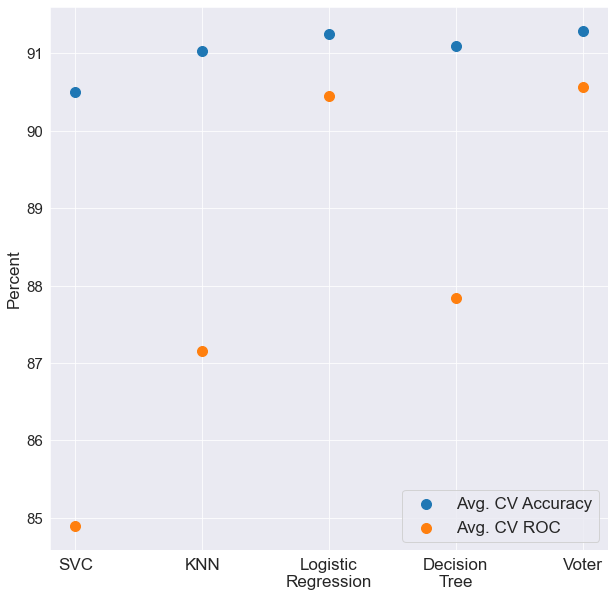

In [52]:
cv_accs = np.array([0.90503649, 0.91023682, 0.91245215, 0.9109748 , 0.91282803])
cv_rocs = np.array([0.84899819, 0.87160194, 0.90451615, 0.87844867, 0.9056101 ])

plt.figure(figsize=(10,10))

plt.scatter(range(5), 100*cv_accs, s=100, label='Avg. CV Accuracy')
plt.scatter(range(5), 100*cv_rocs, s=100, label='Avg. CV ROC')

#plt.xlabel("Model", fontsize=18)
plt.ylabel("Percent", fontsize=17)

plt.yticks(fontsize=15)
plt.xticks(range(5), ['SVC', 'KNN', 'Logistic\nRegression','Decision\nTree','Voter'], fontsize=17)

plt.legend(fontsize=17)

plt.show()







